### Load in DESeq2 Results

As mentioned, I ran DESeq2 in a separate notebook. I ran two tests, one that just compares every stim to the control for every non-zero time point (labeled by the hour in the cell below), and another that tries to model stimulation-specific changes over time (labeled as TC below). I'll read in all, but since I'm not *exactly* sure how to interpret the latter, I'm really only going to focus on the former in this notebook.

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
import pickle as pkl
import itertools as it
from functools import reduce
import scanpy as sc

In [2]:
prefix = '/data/codec/'

In [3]:
conds = ['A', 'B', 'G', 'P', 'R']

In [61]:
cond_dict = {'TNFa': 'A',
             'R848': 'R',
             'PMAI': 'P',
             'IFNG': 'G',
             'IFNB': 'B',
             'Control': 'C'
            } # copied from another notebook, but need to invert here
cond_dict = {v: k for k, v in cond_dict.items()}

Read in the results.

In [62]:
de = dict() # differential expression dictionary
for modality in ['p', 'b']:
    de[modality] = dict()
    
for cond in conds:
    de['p'][cond] = pd.read_csv(prefix + 'production.run/mrna/deseq2.res/pseudobulks/' + cond + '.csv', index_col=0).dropna()  

for cond in conds:
    de['b'][cond] = pd.read_csv(prefix + 'bulk.jan20/deseq2.res/' + cond_dict[cond] + '.9.csv', index_col=0).dropna()

Using the 80th percentile positive log2fc and the p_adj < 0.01, I will now extract out differentially expressed genes.

In [63]:
de_genes = dict() # make a dictionary

for modality in ['b','p']:
    de_genes[modality] = dict()
    for cond in conds: # this has all the conditions
        df = de[modality][cond]
        df = df[df['log2FoldChange'] > 0]
        fc_thresh = np.percentile(df['log2FoldChange'],90)
        de_genes[modality][cond] = df.index[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)
                                   ].tolist() 

In [64]:
for modality in de_genes:
    for cond in conds:
        print(len(de_genes[modality][cond]))

123
274
242
379
328
490
717
667
867
819


In [176]:
df = pd.DataFrame(0, index=conds, columns=conds)

In [177]:
for c1, c2 in tqdm(it.combinations(conds, r=2)):
    df.loc[c2, c1] = len(np.intersect1d(de_genes['b'][c1], de_genes['p'][c2]))/len(np.union1d(de_genes['b'][c1], de_genes['p'][c2]))

In [178]:
for c1 in conds:
    df.loc[c1, c1] = len(np.intersect1d(de_genes['b'][c1], de_genes['p'][c1]))/len(np.union1d(de_genes['b'][c1], de_genes['p'][c1]))

In [179]:
mask = np.zeros_like(df, dtype=np.bool)

In [180]:
mask[np.triu_indices_from(mask, k=1)] = True

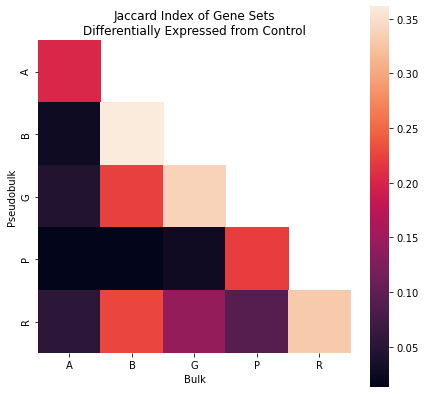

In [181]:
plt.figure(figsize=(7,7))
sns.heatmap(df, mask=mask, square=True)
plt.title('Jaccard Index of Gene Sets\nDifferentially Expressed from Control')
plt.ylabel('Pseudobulk')
plt.xlabel('Bulk');

In [335]:
def standard_triangle(input_arr):
    arr = input_arr.copy()
    assert arr.shape[0] == arr.shape[1]
    dim = arr.shape[0]
    
    mask = np.zeros_like(arr, dtype=np.bool)
    mask[np.triu_indices_from(arr, k=1)] = True
    assert all(arr[mask] == False)
    
    raveled = arr.ravel().copy()
    for i, j in it.combinations_with_replacement(range(arr.shape[0]), r=2):
        vals_with_zeros = raveled[[any([k, m]) for k, m in it.product(np.arange(dim) == j, np.arange(dim) == i)]]
        vals_nonzero = vals_with_zeros[vals_with_zeros != 0]
        ind = (vals_nonzero == arr[j, i]).argmax()
        vals_nonzero = (vals_nonzero - min(vals_nonzero))
        vals_nonzero = vals_nonzero/vals_nonzero.max()
        arr[j, i] = vals_nonzero[ind]
    return arr

In [336]:
arr = df.values.copy()

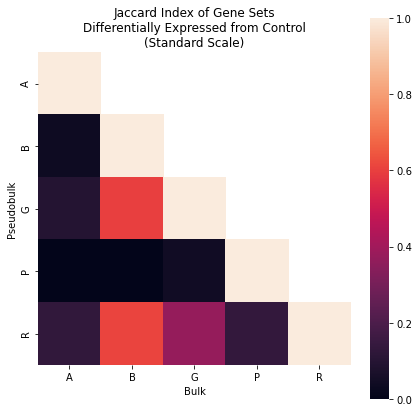

In [344]:
plt.figure(figsize=(7,7))
sns.heatmap(pd.DataFrame(standard_triangle(arr), index=df.index, columns=df.columns), mask=mask, square=True)
plt.title('Jaccard Index of Gene Sets\nDifferentially Expressed from Control\n(Standard Scale)')
plt.ylabel('Pseudobulk')
plt.xlabel('Bulk');

In [339]:
diagonal = df.values.diagonal()

In [340]:
non_diagonal_with_nans = df.mask(np.equal(*np.indices(df.shape))).values.flatten()
non_diagonal = np.unique(non_diagonal_with_nans[~np.isnan(non_diagonal_with_nans)])

In [341]:
df_compare = pd.DataFrame(data=list(zip(['SAME']*len(diagonal),
                           diagonal)) + 
             list(zip(['DIFF']*len(non_diagonal),
                      non_diagonal)), columns=['COMPARISON', 'JACCARD'])

(0.0, 0.5)

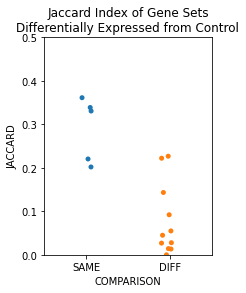

In [342]:
plt.figure(figsize=(3,4))
sns.stripplot(data=df_compare, x='COMPARISON', y='JACCARD');
plt.title('Jaccard Index of Gene Sets\nDifferentially Expressed from Control')
plt.ylim(0.0, 0.5)

In [102]:
de_union = list()
for modality in de:
    for cond in conds:
        de_union.append(de_genes[modality][cond])

In [104]:
de_union = np.unique([i for j in de_union for i in j])

In [109]:
file_path = prefix + 'production.run/mrna/var/de_union.genes.txt'
with open(file_path, 'w') as file:
    for gene in de_union:
        file.write(gene + '\n')

# Figures

In [347]:
fig_prefix = '/data/codec/production.run/figs/'

In [351]:
filename = fig_prefix + 'bulk.compare/jaccard.de.gene.sets.png'
plt.figure(figsize=(7,7))
sns.heatmap(df, mask=mask, square=True)
plt.title('Jaccard Index of Gene Sets\nDifferentially Expressed from Control')
plt.ylabel('Pseudobulk')
plt.xlabel('Bulk');
plt.tight_layout()
plt.savefig(filename, dpi=80)
plt.close()

In [354]:
filename = fig_prefix + 'bulk.compare/jaccard.de.gene.sets.std.scale.png'
plt.figure(figsize=(7,7))
sns.heatmap(pd.DataFrame(standard_triangle(arr), index=df.index, columns=df.columns), mask=mask, square=True)
plt.title('Jaccard Index of Gene Sets\nDifferentially Expressed from Control\n(Standard Scale)')
plt.ylabel('Pseudobulk')
plt.xlabel('Bulk');
plt.tight_layout()
plt.savefig(filename, dpi=80)
plt.close()

In [358]:
filename = fig_prefix + 'bulk.compare/jaccard.de.gene.sets.strip.png'
plt.figure(figsize=(3,4))
sns.stripplot(data=df_compare, x='COMPARISON', y='JACCARD');
plt.title('Jaccard Index of Gene Sets\nDifferentially Expressed from Control')
plt.ylim(0.0, 0.5)
plt.tight_layout()
plt.savefig(filename, dpi=80)
plt.close()

In [82]:
filename = fig_prefix + 'deconvolution/cell.number.matrix.batch.by.expid.png'
plt.figure(figsize=(30,4.5))
sns.heatmap(scheme != '0');
plt.ylabel('Batch')
plt.xlabel('Experimental Donor ID');
plt.savefig(filename, dpi=80)
plt.close()

In [94]:
filename = fig_prefix + 'mito.effects/exp.variables.dont.explain.high.mito.png'

fig, ax = plt.subplots(1, 2, figsize=(12,6))

exp_viabilities = postpool[postpool['count_type'] == 'post_flowmi']['viability'].values
high_mitos = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
ax[0].scatter(exp_viabilities, high_mitos);
r, p = pearsonr(exp_viabilities,high_mitos)
ax[0].text(0.25,0.9, 'r=' + str(r)[:5], size=12, transform=ax[0].transAxes, ha='right')
ax[0].text(0.25,0.85, 'p=' + str(p)[:5], size=12, transform=ax[0].transAxes, ha='right')
ax[0].set_ylabel('Percentage of Cells that \nhave High Percent Mito')
ax[0].set_xlabel('Viability of Pool Right before Loading\n(Countess)');

x = mean_viablities
y = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
ax[1].scatter(x, y);
r, p = pearsonr(x,y)
plt.text(0.35,0.7, 'r=' + str(r)[:5], size=12, transform=ax[1].transAxes, ha='right')
plt.text(0.35,0.65, 'p=' + str(p)[:5], size=12, transform=ax[1].transAxes, ha='right')
ax[1].set_ylabel('Percentage of Cells that \nhave High Percent Mito')
ax[1].set_xlabel('Average Viability of Samples that were\nCounted (FACS) and Pooled');

plt.tight_layout()

plt.savefig(filename, dpi=80)
plt.close()

In [113]:
filename = str(sc.settings.figdir) + '/mito.effects/conditions.dont.explain.high.mito.png'

fig, ax = plt.subplots(1,6,figsize=(30,4.5))
ax[0].set_ylabel('Percentage of Cells that \nhave High Percent Mito')
ax[2].text(1, -0.25, 'Percent of Cells \n Belonging to each Condition', transform=ax[2].transAxes, ha='center')
ax[2].text(1, 1.15, "Conditions Don't Explain Batch-Specific High Mito",fontdict={'fontsize':20}, transform=ax[2].transAxes, ha='center')
for cond, ax in zip(conds, ax):
    x = cond_props[cond].values
    y = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
    ax.scatter(x,y)
    ax.set_title(cond)
    r, p = pearsonr(x,y)
    ax.text(0.95,0.9, 'r=' + str(r)[:5], size=12, transform=ax.transAxes, ha='right')
    ax.text(0.95,0.85, 'p=' + str(p)[:5], size=12, transform=ax.transAxes, ha='right')

plt.savefig(filename, dpi=80)
plt.close()

In [127]:
filename = fig_prefix + 'deconvolution/cell.number.matrix.batch.by.freeid.ordered.png'
plt.figure(figsize=(30,4.5))
sns.heatmap(deconvolution_ordered);
plt.ylabel('Batch');
plt.xlabel('Freemuxlet Donor ID');
plt.savefig(filename, dpi=80)
plt.close()

In [177]:
filename = fig_prefix + '/deconvolution/cell.number.cond.freeid.stacked.bar.png'
labels = deconvolution_ordered.columns.values
counts = dict()

for cond in conds:
    counts[cond] = deconvolution_ordered.values.T[(scheme==cond).values.T]

fig, ax = plt.subplots(figsize=(30,5))
lastpos = [0]*64
for cond in counts:
    ax.bar(labels, counts[cond], label=cond, bottom=lastpos, color=cond_colors[cond])
    lastpos = counts[cond] + lastpos

ax.set_ylabel('Counts')
ax.legend()

plt.savefig(filename, dpi=80)
plt.close()

In [255]:
filename = fig_prefix + '/deconvolution/cell.number.cond.stripplot.png'
plt.figure(figsize=(7,5))
sns.stripplot(data=counts_df,x='cond',y='count');
plt.xlabel('Condition');
plt.xlabel('Counts');
plt.savefig(filename, dpi=80)
plt.close()